In [44]:
import os
import cv2
import json
import torch
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
import os.path as osp
import torch.nn.functional as F
from sklearn.cluster import KMeans
from torchvision import transforms
from transformers import CLIPModel
from torchvision import transforms
from argparse import ArgumentParser
from utils_dir.backbones_utils import load_backbone, extract_backbone_features, get_backbone_params, load_backbone_and_tokenizer, prepare_image_for_backbone
from utils_dir.coco_to_seg import coco_to_seg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
import time
import torchvision
from torchvision import transforms as T
import xml.etree.ElementTree as ET

# Normalization from CoOp
from torchvision.transforms import Normalize
PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]

from build_prototypes import build_object_prototypes
from argparse import ArgumentParser

In [ ]:
from CoOp.clip import clip

def load_clip_to_cpu():
    
    backbone_name = 'ViT-L/14'
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())
    
    ## TODO dont hardcode
    state_dict = torch.load('/home/gridsan/manderson/ovdsat/weights/RemoteCLIP-ViT-L-14.pt', map_location="cpu")
    model = clip.build_model(state_dict)
        
    return model

model = load_clip_to_cpu()
model.eval()
print('Loaded CLIP model')

Loaded CLIP model


In [102]:
# Load text prototype
#N = 30
M = 1

prot_path = f'run/text_prototypes/boxes/mar/prototypes_clip-14.pt'
# prot_path = f'/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/mar_N{N}-{M}/prototypes_remoteclip-14.pt'
prot = torch.load(prot_path)

text_prot = prot['prototypes']

labels = prot['label_names']
print('Labels:', labels)

text_norm = text_prot / text_prot.norm(dim=1, keepdim=True)

Labels: ['SU-35', 'B-1B', 'E-8', 'TU-22', 'F-15', 'KC-135', 'F-22', 'FA-18', 'TU-95', 'KC-1', 'SU-34', 'C-130', 'SU-24', 'C-17', 'C-5', 'F-16', 'TU-160', 'E-3', 'B-52', 'P-3C']


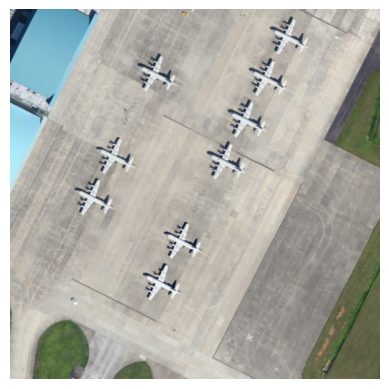

In [103]:
# Load image
img_num = '1209'
img_path = f'/home/gridsan/manderson/ovdsat/data/mar/JPEGImages/{img_num}.jpg' #12523.jpg 09249.jpg 04325.jpg 02112.jpg

# Display
img_display = cv2.imread(img_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
img_display = torch.as_tensor(img_display.astype("float32").transpose(2, 0, 1)) / 255.0
plt.imshow(img_display.permute(1, 2, 0))
plt.axis('off')

PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]
coop_normalize = Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)

# Format
image = cv2.imread(img_path)

val_augmentations = A.Compose([
    A.Resize(602,602),
])
    
transformed = val_augmentations(image=image)
image = torch.as_tensor(transformed['image'].astype("float32").transpose(2, 0, 1))

image = image[[2, 1, 0], :, :] # Change to RGB
normalized_tensor = coop_normalize(image/255.0)

img = normalized_tensor

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

images = img.unsqueeze(0)

patch_size = 14
num_tiles_side = 3 # TODO change from 3 to 1 for CoOp comparison
tile_size = 224
image_size = 602 # TODO change from 602 to 224 for CoOp comparison
B = len(images)
D = 768

# Create full image features tensor and a counter for aggregation
output_features = torch.zeros((B, image_size // patch_size, image_size // patch_size, D)).to(device)
count_tensor = torch.zeros((B, image_size // patch_size, image_size // patch_size,)).to(device)

# Process tiles through CLIP
with torch.no_grad():
    for i in range(num_tiles_side):
        for j in range(num_tiles_side):

            # Update tile coords
            start_i = i * tile_size
            start_j = j * tile_size
            end_i = min(start_i + tile_size, image_size)
            end_j = min(start_j + tile_size, image_size)

            # If tile exceeds, make new tile containing more image content
            if end_i - start_i < tile_size:
                start_i = end_i - tile_size
            if end_j - start_j < tile_size:
                start_j = end_j - tile_size

            # Extract the tile from the original image
            tile = images[:, :, start_i:end_i, start_j:end_j]

            # Get clip visual feats
            image_features = model.to(device).visual(tile.type(model.dtype).to(device)).unsqueeze(1)

            _, K, D = image_features.shape
            p_w = p_h = int(K**0.5)
            image_features = image_features.reshape(B, p_h, p_w, -1)  # Reshape to 2D

            #print(end_i // patch_size)
            # Add features to their location in the original image and track counts per location
            output_features[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += image_features
            count_tensor[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += 1

# Average the overlapping patches
output_features /= count_tensor.unsqueeze(-1)

print(output_features.shape)

torch.Size([1, 43, 43, 768])


In [105]:
feats = output_features.view(output_features.shape[0], -1, output_features.shape[-1])
print(feats.shape)

embeddings = text_norm
batch_size = 100

num_feats = feats.shape[0]
num_classes = embeddings.shape[0]
patch_2d_size = int(np.sqrt(feats.shape[1]))

cosim_list = []
for start_idx in range(0, num_classes, batch_size):
    end_idx = min(start_idx + batch_size, num_classes) #num_classes=20

    embedding_batch = embeddings[start_idx:end_idx]  # Get a batch of embeddings

    ### Modified to exactly match CLIP cosine similarity in CoOp
    feat_norm = (feats / feats.norm(dim=-1, keepdim=True))
    embed_norm = embedding_batch / embedding_batch.norm(dim=-1, keepdim=True)

    feat_norm = feat_norm.float().to(device)
    embed_norm = embed_norm.float().to(device)

    dot_product = (feat_norm @ embed_norm.t())
    dot_product = dot_product.transpose(1, 2)

    # # Softmax
    # dot_product *= model.logit_scale.exp()
    # dot_product = dot_product.softmax(dim=1)

    # Append the similarity scores for this batch to the list
    cosim_list.append(dot_product)

# Concatenate the similarity scores from different batches
cosim = torch.cat(cosim_list, dim=1)

print('\ncosim min and max')
print(cosim.min())
print(cosim.max())

# Reshape to 2D and return class similarity maps
cosim = cosim.reshape(-1, num_classes, patch_2d_size, patch_2d_size)
print('\ncosim')
print(cosim.shape)

# Interpolate cosine similarity maps to original resolution
cosim = F.interpolate(cosim, size=602, mode='bicubic') # try bilinear instead of bicubic?
print(cosim.shape)

#print(cosim[0,:5,:5,:5])

torch.Size([1, 1849, 768])

cosim min and max
tensor(0.0991, device='cuda:0')
tensor(0.2414, device='cuda:0')

cosim
torch.Size([1, 20, 43, 43])
torch.Size([1, 20, 602, 602])


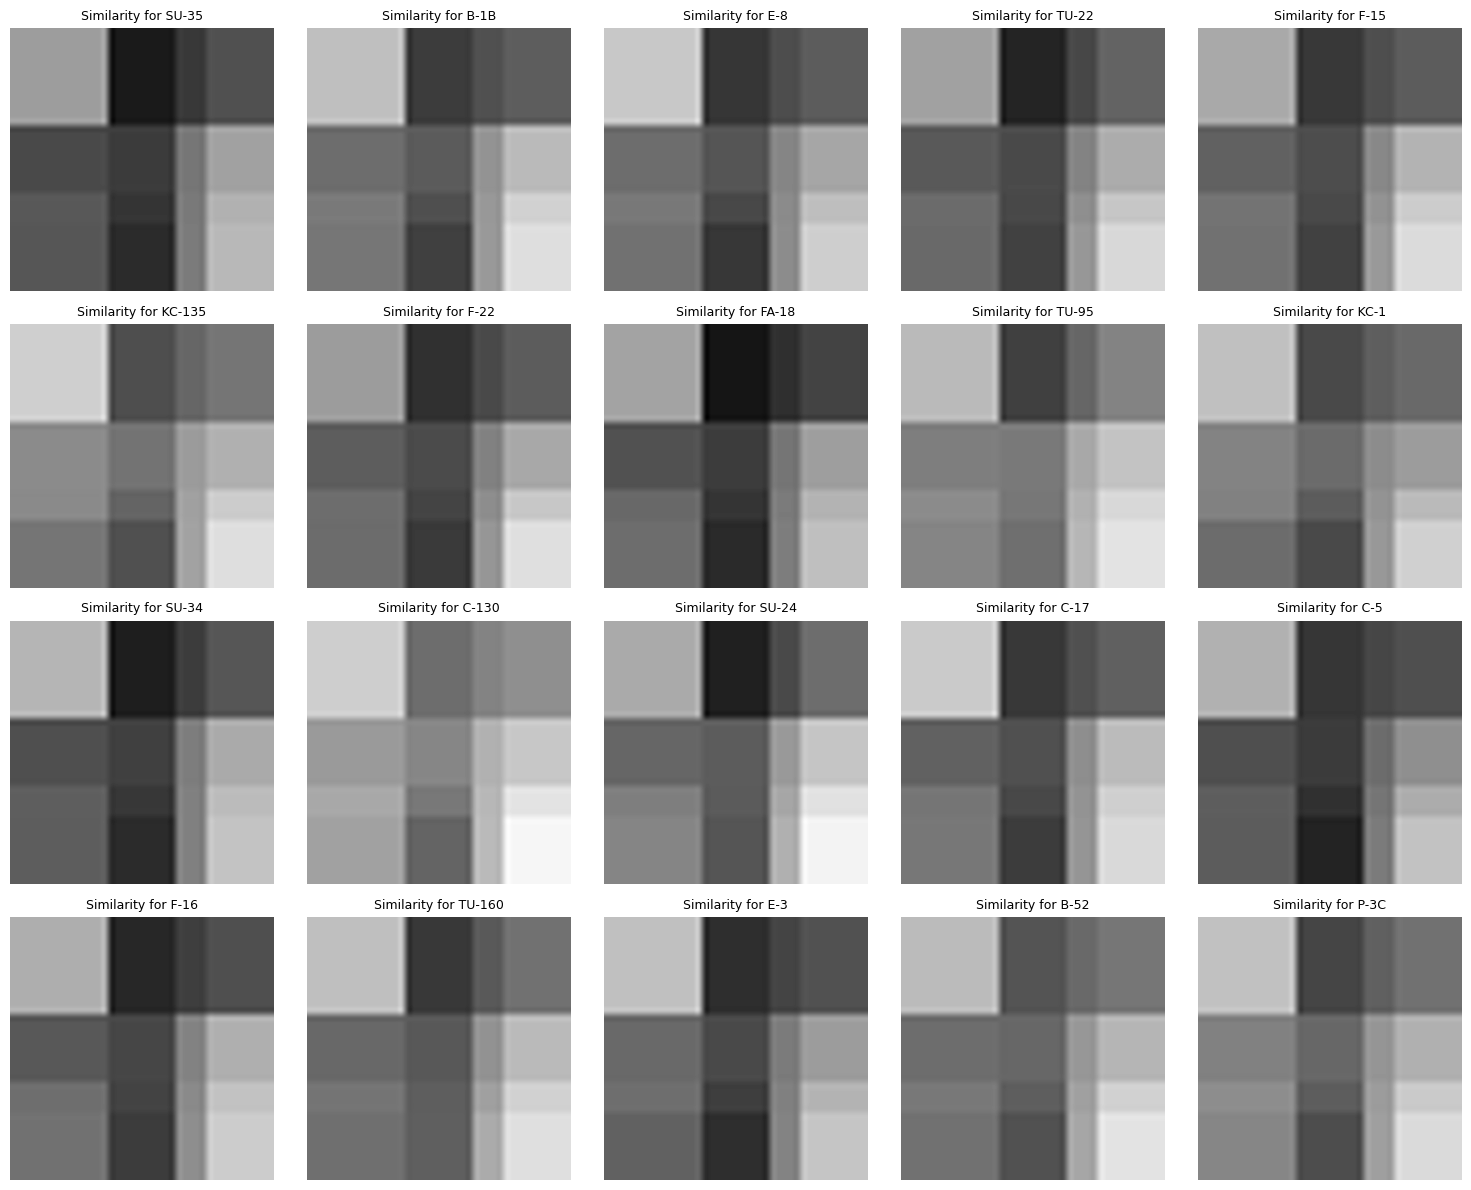

In [106]:
# Visualize sim

# remove batch dimension -> [20, 602, 602]
maps = cosim.squeeze(0)  
num_channels = maps.shape[0]

# compute global min/max across all maps
global_min = maps.min().item()
global_max = maps.max().item()

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(num_channels):
    fmap = maps[i].detach().cpu().numpy()
    axes[i].imshow(fmap, cmap="gray", vmin=global_min, vmax=global_max)
    axes[i].set_title(f"Similarity for {coop_labels[i]}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

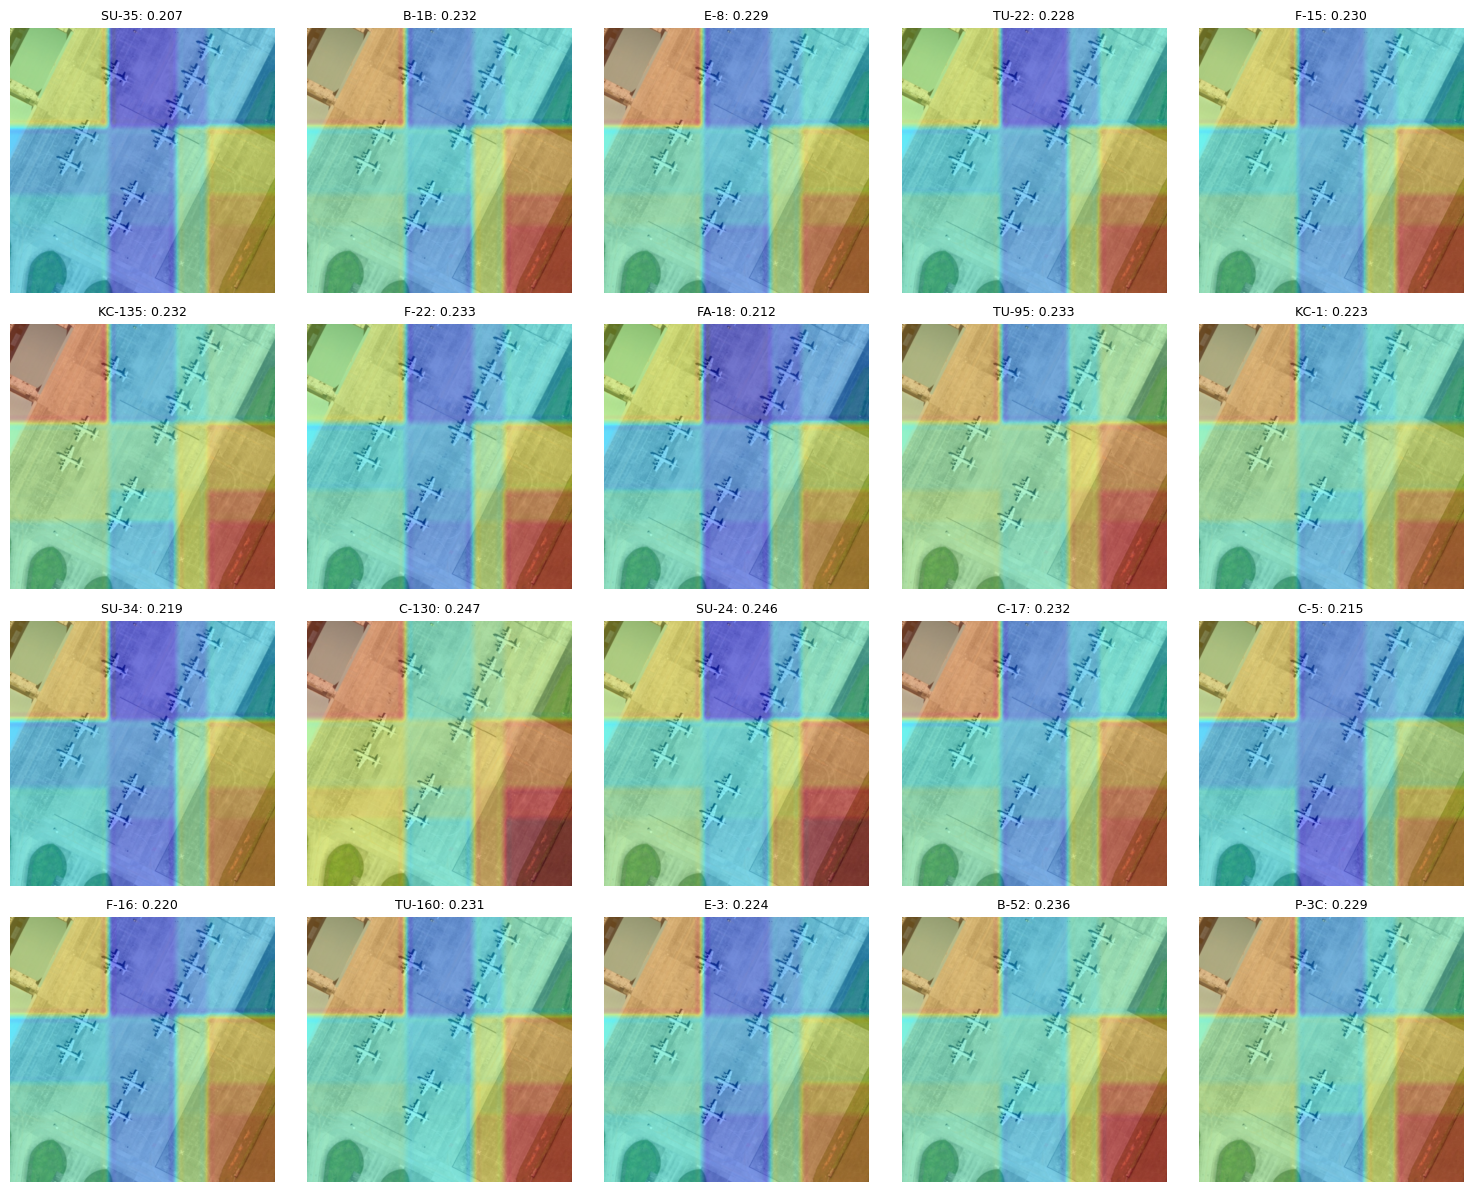

In [107]:
img_np = img.permute(1, 2, 0).detach().cpu().numpy()
img_vis = img_np.copy()
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

global_min = maps.min().item()
global_max = maps.max().item()

for i in range(maps.shape[0]):
    ax = axes[i]
    fmap = maps[i].detach().cpu().numpy()

    ax.imshow(img_vis)
    ax.imshow(fmap, cmap="jet", alpha=0.4, vmin=global_min, vmax=global_max)
    ax.set_title(f'{coop_labels[i]}: {fmap.max():.3f}' , fontsize=9)
    #ax.set_xlabel(f"max={fmap.max():.3f}", fontsize=7)
    ax.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [108]:
from models.rpn.box_rpn import BoxRPN
rpn_config='configs/FasterRCNN_FPN_DOTA_config.yaml'
rpn_checkpoint='weights/FasterRCNN_FPN_DOTA_final_model.pth'
rpn = BoxRPN(rpn_config, rpn_checkpoint)

# try loading like original
# cv2 compare with ovdsat for specific image
transform = transforms.Compose([
    transforms.Resize((602, 602)),
])

rpn_img = cv2.imread(img_path)
rpn_img = torch.as_tensor(rpn_img.astype("float32").transpose(2, 0, 1))
rpn_img = transform(rpn_img)

print(rpn_img.shape)
print(rpn_img.mean())

torch.Size([3, 602, 602])
tensor(166.7499)


/home/gridsan/manderson/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [109]:
device = next(rpn.parameters()).device
rpn_img = rpn_img.unsqueeze(0).to(device)
proposals, proposals_scores = rpn(rpn_img)
print(proposals.shape)
print(proposals_scores.shape)
print(proposals_scores.min())
print(proposals_scores.max())

torch.Size([1, 1000, 4])
torch.Size([1, 1000])
tensor(-0.8930, device='cuda:0')
tensor(0.9914, device='cuda:0')


In [110]:
# From classifier

boxes = proposals
cosine_sim = cosim

cls = None
aggregation='mean'
num_classes = len(coop_labels)

# Gather similarity values inside each box and compute average box similarity
box_similarities = []
B = images.shape[0]
for b in range(B):
    image_boxes = boxes[b][:, :4]

    image_similarities = []
    count = 0
    for i, box in enumerate(image_boxes):
        x_min, y_min, x_max, y_max = box.int()

        if aggregation == 'mean':
            box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max].mean(dim=[1, 2])
        elif aggregation == 'max':
            _,n,h,w = cosine_sim.shape
            box_sim, _ = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1).max(dim=1)
        elif aggregation == 'topk':
            _,n,h,w = cosine_sim.shape
            box_sim = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1)
            topk = k if k <= box_sim.shape[1] else box_sim.shape[1]
            box_sim, _ = box_sim.topk(topk, dim=1)
            box_sim = box_sim.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation method')

        has_nan = torch.isnan(box_sim).any().item()
        image_similarities.append(box_sim)

    box_similarities.append(torch.stack(image_similarities))

box_similarities = torch.stack(box_similarities)  # Shape: [B, max_boxes, N]

# Flatten box_logits and target_labels
box_similarities = box_similarities.view(B, -1, num_classes)

In [111]:
def filter_boxes(boxes, classes, scores, target_size, num_labels, box_conf_threshold=0):
    print(box_conf_threshold)
    
    print('in filter_boxes')
    target_height, target_width = target_size
    keep = ((boxes[:, 0] >= 0) & (boxes[:, 1] >= 0) &
            (boxes[:, 2] <= target_width) & (boxes[:, 3] <= target_height))
    
    print(boxes.shape)

    filtered_boxes = boxes[keep]
    filtered_classes = classes[keep]
    filtered_scores = scores[keep]
    
    print(filtered_boxes.shape)

    # Filter out boxes classified as background
    predictions = torch.argmax(filtered_classes, dim=-1)   
    #print(predictions.shape)
    filtered_boxes = filtered_boxes[predictions < num_labels, ...]
    filtered_classes = filtered_classes[predictions < num_labels, ...]
    filtered_scores = filtered_scores[predictions < num_labels]
    
    print(filtered_boxes.shape)
    
    # Filter out boxes with low confidence
    keep = filtered_scores > box_conf_threshold
    filtered_boxes = filtered_boxes[keep, ...]
    filtered_classes = filtered_classes[keep, ...]
    filtered_scores = filtered_scores[keep]
    
    print(filtered_boxes.shape)
    
    print('done')

    return filtered_boxes, filtered_classes[:, :num_labels], filtered_scores

In [112]:
def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
        isdino=True,
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """
    
    print('NMS debug')
    print(conf_thres, iou_thres, max_det)
    print(prediction.shape)

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    #xc = prediction[..., 4] > conf_thres  # candidates - it ends up filtering out any boxes < conf_thres
    xc = prediction[..., 4] > 0

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence
        print('x')
        print(x.shape)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        #if not isdino:
        x[:, 5:] *= x[:, 4:5]  # conf = class_conf * box_conf
        print('compute conf')
        print(x[:, 5:].shape)
        print(x[:, 4:5].shape)

        # Box/Mask
        if isdino:
            box = x[:, :4]
        else:
            box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            print('in best class only')
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            print(conf)
            # # CHANGE conf_thres
            # conf_thres = 10
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]
            print(x.shape)

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            #LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output

In [113]:
# From detector

#from utils_dir.processing_utils import filter_boxes
#from utils_dir.nms import non_max_suppression

target_size = (602,602)
num_classes = 20
box_conf_threshold = 0.01 # just for initial box filter, should be >= conf_thres since conf_thres does this too
iou_thr = 0.2
conf_thres = 0.1#0.05 # CHANGE? original 0.001 this ends up initially filtering boxes in NMS

B, num_proposals = proposals_scores.shape
print('B', B)
print('num_proposals', num_proposals)
preds = box_similarities

# if num_proposals == 0:
#     return [torch.tensor([], device=images.device) for _ in range(B)]

# Extract class scores and predicted classes
preds = preds.reshape(B, num_proposals, -1)
print(preds.shape)
scores, _ = torch.max(preds, dim=-1)
print(scores.shape)
classes = torch.argmax(preds, dim=-1)
print(classes.shape)

# Filter predictions and prepare for NMS
processed_predictions = []
for b in range(B):
    # Filter and prepare boxes for NMS
    # print('proposals.shape')
    # print(proposals.shape)
    filtered_boxes, filtered_classes, filtered_scores = filter_boxes(proposals[b].cpu(),
                                                                    preds[b].cpu(), # class scores
                                                                    proposals_scores[b].cpu(),
                                                                    target_size,
                                                                    num_classes,
                                                                    box_conf_threshold)
    # print('filtered_boxes.shape')
    # print(filtered_boxes.shape)
    # print(filtered_boxes[0])
    # print('filtered_scores.shape')
    # print(filtered_scores.shape)
    pred_boxes_with_scores = torch.cat([filtered_boxes, filtered_scores[:, None], filtered_classes], dim=1)
    #print('pred_boxes_with_scores.shape')
    #print(pred_boxes_with_scores.shape) # first 4 are box coorindates, 5th is the box score, rest are class scores

    # Use the cosine similarity class score as box confidence scores
    max_cls_scores, _ = torch.max(filtered_classes, dim=-1)
    sorted_indices = torch.argsort(filtered_scores, descending=True)
    pred_boxes_with_scores = pred_boxes_with_scores[sorted_indices]
#     print(pred_boxes_with_scores.shape)

#     print()
    # Apply non maximum suppression
    nms_results = non_max_suppression(pred_boxes_with_scores.unsqueeze(0), iou_thres=iou_thr, conf_thres=conf_thres) 
    # In NMS it takes object conf * class conf!!!
    processed_predictions.append(nms_results[0])

B 1
num_proposals 1000
torch.Size([1, 1000, 20])
torch.Size([1, 1000])
torch.Size([1, 1000])
0.01
in filter_boxes
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([40, 4])
done
NMS debug
0.1 0.2 300
torch.Size([1, 40, 25])
x
torch.Size([40, 25])
compute conf
torch.Size([40, 20])
torch.Size([40, 1])
in best class only
tensor([[0.1918],
        [0.1682],
        [0.1567],
        [0.1565],
        [0.1520],
        [0.1546],
        [0.1542],
        [0.1479],
        [0.1334],
        [0.1393],
        [0.1266],
        [0.1249],
        [0.1158],
        [0.1252],
        [0.1091],
        [0.1081],
        [0.0937],
        [0.1022],
        [0.0875],
        [0.0900],
        [0.0724],
        [0.0643],
        [0.0603],
        [0.0578],
        [0.0512],
        [0.0470],
        [0.0398],
        [0.0377],
        [0.0319],
        [0.0244],
        [0.0254],
        [0.0218],
        [0.0178],
        [0.0174],
        [0.0127],
        [0.0126],
     

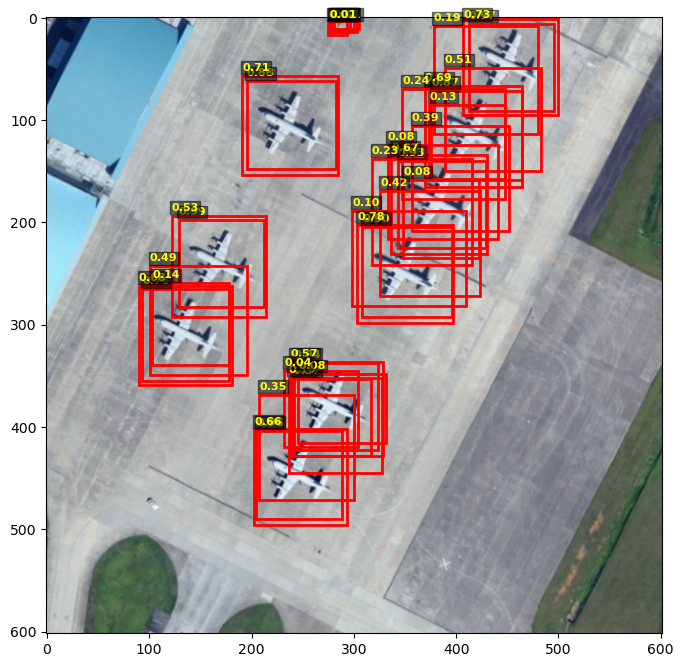

In [114]:
# Visualize the filtered boxes
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_vis)

i = 0
for box in filtered_boxes:
    score = filtered_scores[i]
    x1, y1, x2, y2 = box

    # draw rectangle
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # add label and score
    ax.text(
        x1, max(y1 - 5, 0),
        f"{score:.2f}",
        color="yellow", fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )
    i += 1

plt.show()

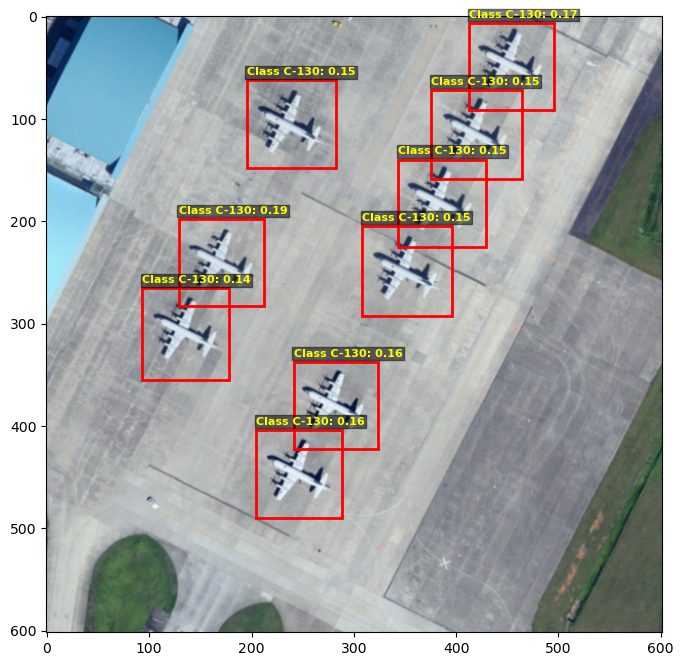

In [115]:
# Show prediction
preds = processed_predictions[0].detach().cpu()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_vis)

for box in preds:
    x1, y1, x2, y2, score, label = box.tolist()

    # draw rectangle
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # add label and score
    ax.text(
        x1, max(y1 - 5, 0),
        f"Class {coop_labels[int(label)]}: {score:.2f}",
        color="yellow", fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )

plt.show()

In [116]:
# Plot ground truth

def plot_gt_from_xml(img_vis, xml_path, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.imshow(img_vis)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall("object"):
        cls_name = obj.find("name").text

        bndbox = obj.find("bndbox")
        x1 = int(bndbox.find("xmin").text)
        y1 = int(bndbox.find("ymin").text)
        x2 = int(bndbox.find("xmax").text)
        y2 = int(bndbox.find("ymax").text)
        
        orig_h, orig_w = int(root.find("size/height").text), int(root.find("size/width").text)
        new_h, new_w = img_vis.shape[:2]

        sx, sy = new_w / orig_w, new_h / orig_h

        x1 = int(x1 * sx)
        x2 = int(x2 * sx)
        y1 = int(y1 * sy)
        y2 = int(y2 * sy)

        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="lime",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            max(y1 - 5, 0),
            cls_name,
            color="black",
            fontsize=8,
            weight="bold",
            bbox=dict(facecolor="lime", alpha=0.7, pad=1)
        )

    ax.axis("off")
    return ax

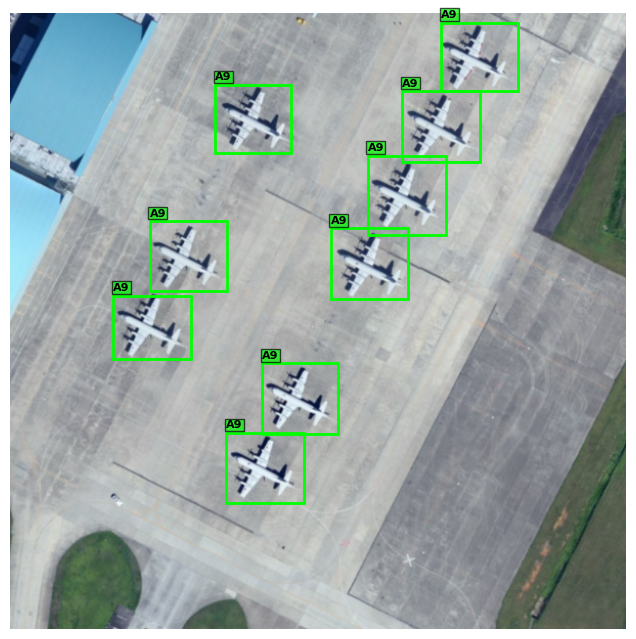

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_gt_from_xml(img_vis, f"/home/gridsan/manderson/ovdsat/data/mar/Annotations/Horizontal Bounding Boxes/{img_num}.xml", ax=ax)
plt.show()